In [23]:
#Librairie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Activation


from optuna.integration import TFKerasPruningCallback





In [24]:
# Configuration (si GPU disponible)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponibles: {len(gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("Aucun GPU détecté, utilisation du CPU.")

Aucun GPU détecté, utilisation du CPU.


In [25]:
# chargement des données
base_path = r"ENetFall_dataset_trained_networks"

dataset_files = [
    r"dataset_home_lab(L).mat",
    r"dataset_home_lab(R).mat",
    r"dataset_lecture_room.mat",
    r"dataset_living_room.mat",
    r"dataset_meeting_room.mat"
]

signals = []
labels = []

for file_name in dataset_files:
    path = fr"{base_path}\{file_name}"
    try:
        data_mat = sio.loadmat(path)
        signals.append(data_mat['dataset_CSI_t'])
        labels.append(data_mat['dataset_labels'].squeeze())
        print(f"Chargé: {file_name}, Signaux: {data_mat['dataset_CSI_t'].shape}, Étiquettes: {data_mat['dataset_labels'].squeeze().shape}")
    except Exception as e:
        print(f"Erreur avec {path}: {e}")

if not signals:
    raise ValueError("Aucune donnée n'a été chargée.")

data_all = np.concatenate(signals, axis=0)
labels_all = np.concatenate(labels, axis=0)

print(f"\nDonnées totales - signaux: {data_all.shape}, étiquettes: {labels_all.shape}")

Chargé: dataset_home_lab(L).mat, Signaux: (85, 625, 90), Étiquettes: (85,)
Chargé: dataset_home_lab(R).mat, Signaux: (85, 625, 90), Étiquettes: (85,)
Chargé: dataset_lecture_room.mat, Signaux: (205, 625, 90), Étiquettes: (205,)
Chargé: dataset_living_room.mat, Signaux: (248, 625, 90), Étiquettes: (248,)
Chargé: dataset_meeting_room.mat, Signaux: (134, 625, 90), Étiquettes: (134,)

Données totales - signaux: (757, 625, 90), étiquettes: (757,)


#### 1. On considére les 22 participants et les 4 environnements comme connus et on les intégre dans l’entrainement.

In [26]:
# prétraitement des données

# Reshape pour CNN: (Nombre d'échantillons, Hauteur, Largeur, Canaux)
# c'est ce qui est attendu en entrée dans un CNN
# (N, 625, 90) -> (N, 625, 30, 3) après réorganisation et transposition
instances = data_all.shape[0]
timesamples = data_all.shape[1] # 625
subcarriers = data_all.shape[2] # 90
width = subcarriers // 3 # 30

data = np.ndarray(shape=(instances, 3, timesamples, width))
data[:, 0, :, :] = data_all[:, :, 0:subcarriers:3]
data[:, 1, :, :] = data_all[:, :, 1:subcarriers:3]
data[:, 2, :, :] = data_all[:, :, 2:subcarriers:3]

# Transposer pour TensorFlow: (N, timesamples, width, 3)
data_tf = np.transpose(data, (0, 2, 3, 1))
print(f"Forme des données pour TensorFlow: {data_tf.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    data_tf, labels_all,
    test_size=0.25,
    random_state=42,
    stratify=labels_all
)



Forme des données pour TensorFlow: (757, 625, 30, 3)


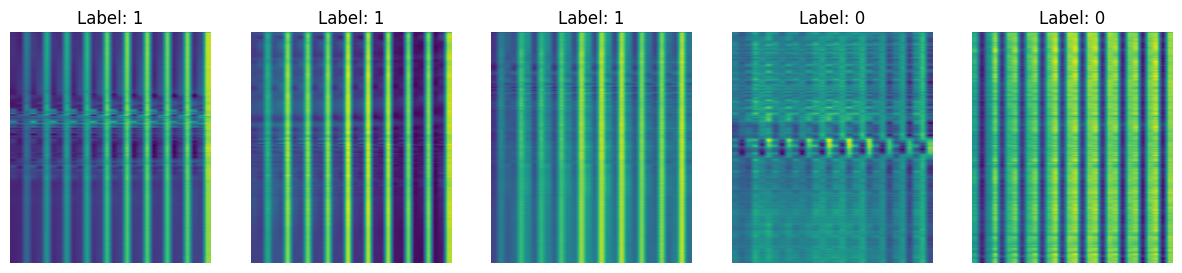

In [27]:
#Test affichage de données

import matplotlib.pyplot as plt

def afficher_exemples(X, y, n=5):
    """
    Affiche n exemples de données d'entraînement.
    X : données (N, 625, 30, 3)
    y : labels (N,)
    n : nombre d'exemples à afficher
    """
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i, :, :, 0], aspect='auto', cmap='viridis')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.show()

afficher_exemples(X_train, y_train)

In [35]:
#normalisation
train_max = np.max(X_train)
train_mean = np.mean(X_train / train_max)

X_train_normalized = (X_train / train_max) - train_mean
X_test_normalized = (X_test / train_max) - train_mean

#séparation des données
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_normalized)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_normalized, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

input_shape = X_train_normalized.shape[1:]

#Modèle 1 : CNN 3 couches de convolution 

model_1 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid') 
])

model_1.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
)
model_1.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 623, 28, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 311, 14, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 309, 12, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 154, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 152, 4, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 38912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     2,490,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,546,817 (9.72 MB)

 Trainable params: 2,546,817 (9.72 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
#Entrainement modèle 1

epochs = 30

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = model_1.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

print("\nÉvaluation sur l'ensemble de test:")
results = model_1.evaluate(test_dataset)
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Precision: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.5747 - loss: 0.6746 - precision: 0.4943 - recall: 0.3188 - val_accuracy: 0.6000 - val_loss: 0.6706 - val_precision: 0.5532 - val_recall: 0.3210
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.6148 - loss: 0.6348 - precision: 0.5637 - recall: 0.3308 - val_accuracy: 0.6895 - val_loss: 0.6311 - val_precision: 0.6667 - val_recall: 0.5432
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6401 - loss: 0.6282 - precision: 0.6918 - recall: 0.3535 - val_accuracy: 0.6947 - val_loss: 0.5847 - val_precision: 0.8966 - val_recall: 0.3210
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.7023 - loss: 0.5638 - precision: 0.7254 - recall: 0.5416 - val_accuracy: 0.6947 - val_loss: 0.5565 - val_precision: 0.6825 - val_recall: 0.5309
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.7613 - loss: 0.5130 - precision: 0.7830 - recall: 0.6299 - val_accuracy: 0.7368 - val_loss: 0.

In [37]:
# Évaluation du modèle 1 phase1
results_model_1 = []
model_name = "CNN simple"

print(f"Évaluation de : {model_name}")

eval_train = model_1.evaluate(X_train_normalized, y_train.astype(np.float32), verbose=0)
results_model_1.append({
    "Modèle": model_name,
    "Set": "Train",
    "Loss": f"{eval_train[0]:.4f}",
    "Accuracy": f"{eval_train[1]:.4f}",
    "Precision": f"{eval_train[2]:.4f}",
    "Recall": f"{eval_train[3]:.4f}"
})


eval_test = model_1.evaluate(X_test_normalized, y_test.astype(np.float32), verbose=0)
results_model_1.append({
    "Modèle": model_name,
    "Set": "Test",
    "Loss": f"{eval_test[0]:.4f}",
    "Accuracy": f"{eval_test[1]:.4f}",
    "Precision": f"{eval_test[2]:.4f}",
    "Recall": f"{eval_test[3]:.4f}"
})


df_results_model_1 = pd.DataFrame(results_model_1)

print("\n\nTableau Récapitulatif des Performances du Modèle 1:\n")
print(df_results_model_1.to_markdown(index=False))


Évaluation de : CNN simple


Tableau Récapitulatif des Performances du Modèle 1:

| Modèle     | Set   |   Loss |   Accuracy |   Precision |   Recall |
|:-----------|:------|-------:|-----------:|------------:|---------:|
| CNN simple | Train | 0.3035 |     0.8571 |      0.8412 |   0.8167 |
| CNN simple | Test  | 0.3936 |     0.8316 |      0.7952 |   0.8148 |


In [38]:
#Modèle hybride avec MobileNet et Couche Dense classique (Sigmoid vu qu'on est en binaire)
#J'ai testé VGG16 mais c'est largement mieux avec MobileNetV2

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Redimensionner les données pour VGG16
def resize(X):
    return tf.image.resize(X, [64, 64])

X_train_resized = resize(X_train_normalized)
X_test_resized = resize(X_test_normalized)

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_resized, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_resized)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_resized, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Créer le modèle hybride avec VGG16
base_model = MobileNetV2(
    input_shape=(64, 64, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # gèle

hybrid_model = Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
hybrid_model.summary()




C:\Users\simon\AppData\Local\Temp\ipykernel_11092\464588757.py:26: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
# Entraînement du modèle hybride

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = hybrid_model.fit(
    train_dataset,
    epochs=30,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

print("\nÉvaluation sur l'ensemble de test:")
results = hybrid_model.evaluate(test_dataset)
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Precision: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.5895 - loss: 0.6912 - precision: 0.5503 - recall: 0.5421 - val_accuracy: 0.7579 - val_loss: 0.4957 - val_precision: 0.7333 - val_recall: 0.6790
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7805 - loss: 0.4887 - precision: 0.7298 - recall: 0.7158 - val_accuracy: 0.7842 - val_loss: 0.4488 - val_precision: 0.7326 - val_recall: 0.7778
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7969 - loss: 0.4427 - precision: 0.7547 - recall: 0.7285 - val_accuracy: 0.8000 - val_loss: 0.4631 - val_precision: 0.7216 - val_recall: 0.8642
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7921 - loss: 0.4270 - precision: 0.7835 - recall: 0.7470 - val_accuracy: 0.8053 - val_loss: 0.4205 - val_precision: 0.7750 - val_recall: 0.7654
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8247 - loss: 0.3762 - precision: 0.8090 - recall: 0.7539 - val_accuracy: 0.8053 - val_loss: 0.4076

In [40]:
# Évaluation du modèle hybride

results_hybrid_model = []
model_name = "Hybrid MobileNetV2"

print(f"Évaluation de : {model_name}")

eval_train = hybrid_model.evaluate(X_train_resized, y_train.astype(np.float32), verbose=0)
results_hybrid_model.append({
    "Modèle": model_name,
    "Set": "Train",
    "Loss": f"{eval_train[0]:.4f}",
    "Accuracy": f"{eval_train[1]:.4f}",
    "Precision": f"{eval_train[2]:.4f}",
    "Recall": f"{eval_train[3]:.4f}"
})

eval_test = hybrid_model.evaluate(X_test_resized, y_test.astype(np.float32), verbose=0)
results_hybrid_model.append({
    "Modèle": model_name,
    "Set": "Test",
    "Loss": f"{eval_test[0]:.4f}",
    "Accuracy": f"{eval_test[1]:.4f}",
    "Precision": f"{eval_test[2]:.4f}",
    "Recall": f"{eval_test[3]:.4f}"
})

df_results_hybrid_model = pd.DataFrame(results_hybrid_model)

print("\n\nTableau Récapitulatif des Performances du Modèle Hybride:\n")
print(df_results_hybrid_model.to_markdown(index=False))


Évaluation de : Hybrid MobileNetV2


Tableau Récapitulatif des Performances du Modèle Hybride:

| Modèle             | Set   |   Loss |   Accuracy |   Precision |   Recall |
|:-------------------|:------|-------:|-----------:|------------:|---------:|
| Hybrid MobileNetV2 | Train | 0.2592 |     0.8995 |      0.8927 |   0.8667 |
| Hybrid MobileNetV2 | Test  | 0.3892 |     0.8474 |      0.8171 |   0.8272 |


In [50]:

# Modèle CNN-LSTM
#normalisation
train_max = np.max(X_train)
train_mean = np.mean(X_train / train_max)

X_train_normalized = (X_train / train_max) - train_mean
X_test_normalized = (X_test / train_max) - train_mean

# ajout de la dimension canal pcq on utilise timeDistributed
X_train_normalized = np.expand_dims(X_train_normalized, axis=-1)  # (567, 625, 30, 3, 1)
X_test_normalized = np.expand_dims(X_test_normalized, axis=-1)


batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_normalized)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_normalized, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

input_shape = X_train_normalized.shape[1:]  # (625, 30, 3, 1)


#TimeDistributed c'est genre une couche  de Keras qui applique la même opération à chaque pas de temps 
model_cnn_lstm = models.Sequential([
    # Bloc convolutionnel
    layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')),
    layers.TimeDistributed(layers.Dropout(0.25)),
    
    layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D((2, 2), padding='same')),
    layers.TimeDistributed(layers.Dropout(0.25)),
    
    # Aplatir chaque frame pour LSTM
    layers.TimeDistributed(layers.Flatten()),  
    
    # Partie LSTM
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),  # meilleure modélisation temporelle
    layers.Dropout(0.3),

    # Dense pour classification
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model_cnn_lstm.summary()




C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_18             │ (None, 625, 30, 3, 32) │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 625, 30, 3, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 625, 15, 2, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 625, 15, 2, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 625, 15, 2, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 625, 15, 2, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 625, 8, 1, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 625, 8, 1, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 625, 512)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,201 (1.23 MB)

 Trainable params: 322,881 (1.23 MB)

 Non-trainable params: 320 (1.25 KB)

In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history_cnn_lstm = model_cnn_lstm.fit(
    train_dataset, 
    epochs=50, 
    validation_data=test_dataset, 
    callbacks=[early_stopping] 
 )



Epoch 1/50


KeyboardInterrupt: 

In [46]:
# Évaluation du modèle CNN-LSTM
results_cnn_lstm = []
model_name = "CNN-LSTM"

print(f"Évaluation détaillée de : {model_name}")

# Évaluation sur l'ensemble d'entraînement
print(f"  Shape des données d'entraînement normalisées pour évaluation : {X_train_normalized.shape}, {y_train.shape}")
eval_train = model_cnn_lstm.evaluate(X_train_normalized, y_train.astype(np.float32), verbose=0)
results_cnn_lstm.append({
    "Modèle": model_name,
    "Set": "Train",
    "Loss": f"{eval_train[0]:.4f}",
    "Accuracy": f"{eval_train[1]:.4f}",
    "Precision": f"{eval_train[2]:.4f}",
    "Recall": f"{eval_train[3]:.4f}"
})
print(f"  Train - Loss: {eval_train[0]:.4f}, Accuracy: {eval_train[1]:.4f}, Precision: {eval_train[2]:.4f}, Recall: {eval_train[3]:.4f}")

# Évaluation sur l'ensemble test/validation
print(f"  Shape des données test normalisées pour évaluation : {X_test_normalized.shape}, {y_test.shape}")
eval_test = model_cnn_lstm.evaluate(X_test_normalized, y_test.astype(np.float32), verbose=0)
results_cnn_lstm.append({
    "Modèle": model_name,
    "Set": "Test",
    "Loss": f"{eval_test[0]:.4f}",
    "Accuracy": f"{eval_test[1]:.4f}",
    "Precision": f"{eval_test[2]:.4f}",
    "Recall": f"{eval_test[3]:.4f}"
})
print(f"  Test - Loss: {eval_test[0]:.4f}, Accuracy: {eval_test[1]:.4f}, Precision: {eval_test[2]:.4f}, Recall: {eval_test[3]:.4f}")

df_results_cnn_lstm = pd.DataFrame(results_cnn_lstm)

print("\nTableau récapitulatif des performances du CNN-LSTM :\n")
print(df_results_cnn_lstm.to_markdown(index=False))


Évaluation détaillée de : CNN-LSTM
  Shape des données d'entraînement normalisées pour évaluation : (567, 625, 30, 3), (567,)
  Train - Loss: 0.2519, Accuracy: 0.9083, Precision: 0.9052, Recall: 0.8750
  Shape des données test normalisées pour évaluation : (190, 625, 30, 3), (190,)
  Test - Loss: 0.4086, Accuracy: 0.8000, Precision: 0.7654, Recall: 0.7654

Tableau récapitulatif des performances du CNN-LSTM :

| Modèle   | Set   |   Loss |   Accuracy |   Precision |   Recall |
|:---------|:------|-------:|-----------:|------------:|---------:|
| CNN-LSTM | Train | 0.2519 |     0.9083 |      0.9052 |   0.875  |
| CNN-LSTM | Test  | 0.4086 |     0.8    |      0.7654 |   0.7654 |


#### 2. Deux environnements et participants inconnus pour le test, avec augmentation de données

Pour cette partie, nous allons simuler un scénario plus réaliste où le modèle est testé sur des environnements et des participants qu'il n'a jamais vus pendant l'entraînement.
- Environnements d'entraînement : `env1`, `env2`
- Environnements de test : `env3`, `env4` (considérés comme inconnus)
Nous utiliserons l'augmentation de données sur l'ensemble d'entraînement pour améliorer la robustesse du modèle.

In [2]:
import os
import scipy.io as sio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Séparation des données pour la Partie 2
dataset_base_path = r"ENetFall_dataset_trained_networks"

file_to_env_mapping = {
    "dataset_home_lab(L).mat": "env1",
    "dataset_home_lab(R).mat": "env1",
    "dataset_lecture_room.mat": "env2",
    "dataset_living_room.mat": "env3",
    "dataset_meeting_room.mat": "env4"
}

files_to_load = [
    "dataset_home_lab(L).mat",
    "dataset_home_lab(R).mat",
    "dataset_lecture_room.mat",
    "dataset_living_room.mat",
    "dataset_meeting_room.mat"
]

train_envs = ['env1', 'env2']
test_envs= ['env3', 'env4']

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

print("Début du chargement des données pour la Partie 2...")

for filename in files_to_load:
    file_path = os.path.join(dataset_base_path, filename)
    conceptual_env = file_to_env_mapping[filename]

    mat_content = sio.loadmat(file_path)
    csi_data_samples = mat_content['dataset_CSI_t']
    label_samples = mat_content['dataset_labels'].squeeze()

    if label_samples.ndim == 0:
        label_samples = np.array([label_samples.item()])
    elif label_samples.ndim > 1 and label_samples.shape[0] != 1 and label_samples.shape[1] == 1:
        label_samples = label_samples.ravel()

    print(f"Chargé: {filename} (Env: {conceptual_env}), Signaux: {csi_data_samples.shape}, Étiquettes: {label_samples.shape}")

    if conceptual_env in train_envs:
        X_train_list.append(csi_data_samples)
        y_train_list.append(label_samples)
    elif conceptual_env in test_envs:
        X_test_list.append(csi_data_samples)
        y_test_list.append(label_samples)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print(f"Partie 2 - Données d'entraînement: {X_train.shape}, Étiquettes d'entraînement: {y_train.shape}")
print(f"Partie 2 - Données de test: {X_test.shape}, Étiquettes de test: {y_test.shape}")
print(f"Échantillons 'chute' dans l'entraînement (Partie 2): {np.sum(y_train == 1)}")
print(f"Échantillons 'chute' dans le test (Partie 2): {np.sum(y_test == 1)}")


Début du chargement des données pour la Partie 2...
Chargé: dataset_home_lab(L).mat (Env: env1), Signaux: (85, 625, 90), Étiquettes: (85,)
Chargé: dataset_home_lab(R).mat (Env: env1), Signaux: (85, 625, 90), Étiquettes: (85,)
Chargé: dataset_lecture_room.mat (Env: env2), Signaux: (205, 625, 90), Étiquettes: (205,)
Chargé: dataset_living_room.mat (Env: env3), Signaux: (248, 625, 90), Étiquettes: (248,)
Chargé: dataset_meeting_room.mat (Env: env4), Signaux: (134, 625, 90), Étiquettes: (134,)
Partie 2 - Données d'entraînement: (375, 625, 90), Étiquettes d'entraînement: (375,)
Partie 2 - Données de test: (382, 625, 90), Étiquettes de test: (382,)
Échantillons 'chute' dans l'entraînement (Partie 2): 172
Échantillons 'chute' dans le test (Partie 2): 149


In [3]:
#Prétraitement des Données (Reshape et Normalisation)

# Paramètres de dimensions
n_train, t, sc = X_train.shape
n_test = X_test.shape[0]
w = sc // 3

# Reshape des données d'entraînement
x_train = np.empty((n_train, 3, t, w), dtype=np.float32)
x_train[:, 0, :, :] = X_train[:, :, 0::3]
x_train[:, 1, :, :] = X_train[:, :, 1::3]
x_train[:, 2, :, :] = X_train[:, :, 2::3]
x_train = np.transpose(x_train, (0, 2, 3, 1))

# Reshape des données de test
x_test = np.empty((n_test, 3, t, w), dtype=np.float32)
x_test[:, 0, :, :] = X_test[:, :, 0::3]
x_test[:, 1, :, :] = X_test[:, :, 1::3]
x_test[:, 2, :, :] = X_test[:, :, 2::3]
x_test = np.transpose(x_test, (0, 2, 3, 1))

# Normalisation (basée sur x_train uniquement)
xmax = np.max(x_train)
xmean = np.mean(x_train / xmax)

x_train = (x_train / xmax) - xmean
x_test = (x_test / xmax) - xmean

input_shape = x_train.shape[1:]

print(f"Shape train : {x_train.shape}")
print(f"Shape test : {x_test.shape}")


Shape train : (375, 625, 30, 3)
Shape test : (382, 625, 30, 3)


Affichage des données originales vs augmentées...


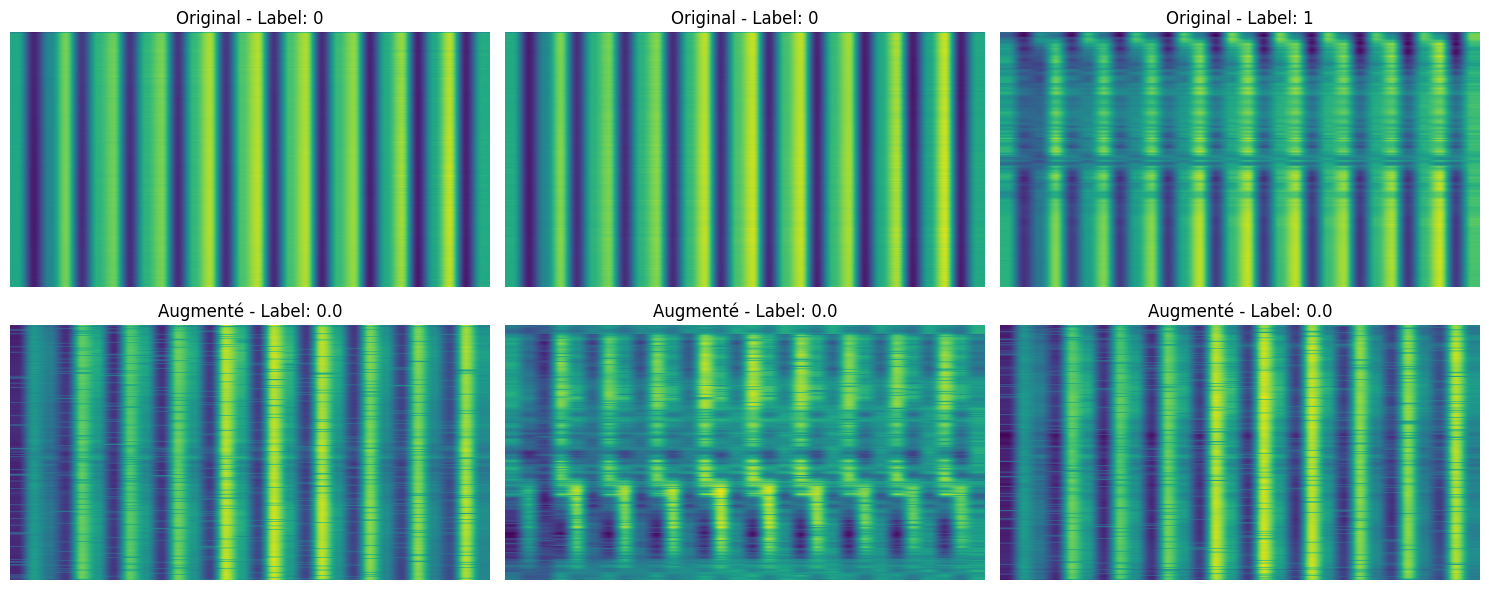

In [4]:
#Augmentation de Données et Création des Datasets TensorFlow 

@tf.function
def augment(signal, label, noise_factor=0.05, max_shift_percent=0.05, dropout_rate=0.05):
    """
    Applique une augmentation simple sur les signaux :
    - Bruit gaussien léger
    - Décalage temporel
    - Masquage aléatoire de points (dropout temporel)
    """

    # 1. Bruit Gaussien
    std = tf.math.reduce_std(signal)
    noise = tf.random.normal(tf.shape(signal), mean=0.0, stddev=std * noise_factor)
    signal = signal + noise

    # 2. Décalage temporel (shift)
    time_steps = tf.shape(signal)[0]
    max_shift = tf.cast(tf.cast(time_steps, tf.float32) * max_shift_percent, tf.int32)
    shift = tf.random.uniform((), -max_shift, max_shift + 1, dtype=tf.int32)
    signal = tf.roll(signal, shift=shift, axis=0)

    # 3. Masquage aléatoire (dropout temporel)
    dropout_mask = tf.cast(tf.random.uniform(tf.shape(signal)) > dropout_rate, signal.dtype)
    signal = signal * dropout_mask

    return signal, label



batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train.astype(np.float32)))
train_ds = train_ds.shuffle(len(x_train))
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test.astype(np.float32)))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- Visualisation des Données Augmentées ---

print("Affichage des données originales vs augmentées...")

n_show = 3
orig = x_train[:n_show]
labels = y_train[:n_show]

aug_batch = next(iter(train_ds.take(1)))
aug = aug_batch[0][:n_show]
aug_labels = aug_batch[1][:n_show]

plt.figure(figsize=(15, 6))
for i in range(n_show):
    plt.subplot(2, n_show, i + 1)
    plt.imshow(orig[i, :, :, 0], aspect='auto', cmap='viridis')
    plt.title(f"Original - Label: {labels[i]}")
    plt.axis('off')
    
    plt.subplot(2, n_show, i + 1 + n_show)
    plt.imshow(aug[i, :, :, 0].numpy(), aspect='auto', cmap='viridis')
    plt.title(f"Augmenté - Label: {aug_labels[i].numpy()}")
    plt.axis('off')

plt.tight_layout()
plt.show()


C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 625, 30, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 313, 15, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 313, 15, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 313, 15, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 157, 8, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 157, 8, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 157, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,329 (669.25 KB)

 Trainable params: 171,329 (669.25 KB)

 Non-trainable params: 0 (0.00 B)


Entraînement du modèle pour la Partie 2...
Epoch 1/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - accuracy: 0.5011 - loss: 1.0974 - precision: 0.4073 - recall: 0.2031 - val_accuracy: 0.6099 - val_loss: 1.0584 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.5335 - loss: 1.0652 - precision: 0.3876 - recall: 0.0446 - val_accuracy: 0.6099 - val_loss: 1.0358 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 926ms/step - accuracy: 0.5343 - loss: 1.0400 - precision: 0.4669 - recall: 0.1195 - val_accuracy: 0.6099 - val_loss: 1.0181 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5123 - loss: 1.0158 - precision: 0.4855 - recall: 0.2127 - val_accuracy: 0.6099 - val_loss: 0.9975 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5536 - loss: 0.9917 - precision: 0

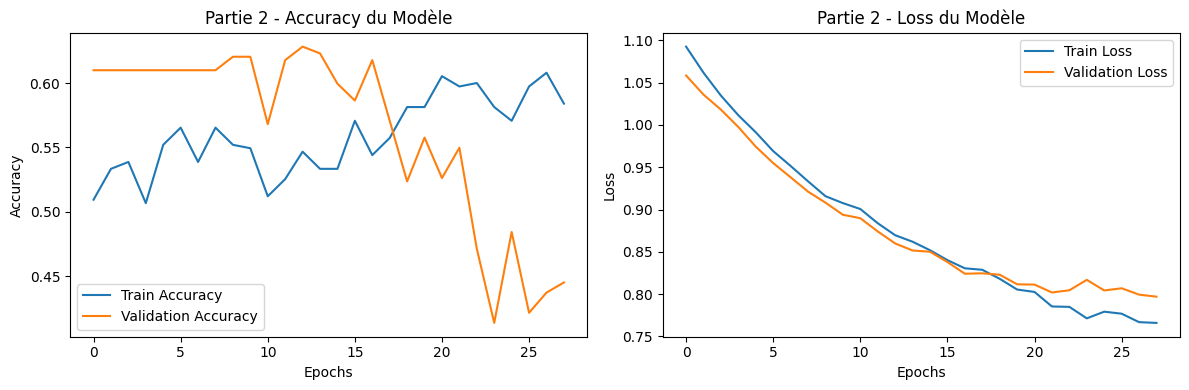